In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Step 1: Load the data from the CSV file
file1 = '/content/drive/MyDrive/historical_data/with_volatility/CNBK_with_volatility.csv'
df = pd.read_csv(file1)

In [ ]:
# Step 2: Preprocessing
def preprocess_data(df, feature='Price', lookback=60):
    # Scaling the data to values between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[[feature]].values)

    # Create the training data in the form of sequences (lookback days of data)
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, 0])  # Input sequence
        y.append(scaled_data[i, 0])             # Corresponding output (next day's price)

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time_steps, features]
    return X, y, scaler

# Preprocess the data
lookback = 120  # Use past 60 days of data to predict the next price
X, y, scaler = preprocess_data(df)

# Split data into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [ ]:
# Step 3: Build the LSTM Model
model = Sequential()
# Stacked LSTM layers with dropout
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Add dropout to prevent overfitting
model.add(LSTM(units=100))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint('best_model.keras', save_best_only=True)
    ]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Step 4: Train the LSTM model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - loss: 0.0461 - val_loss: 5.5142e-04
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0018 - val_loss: 4.8332e-04
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0016 - val_loss: 3.8096e-04
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - loss: 0.0016 - val_loss: 3.8507e-04
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0018 - val_loss: 4.5811e-04
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0015 - val_loss: 3.9921e-04
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - loss: 0.0014 - val_loss: 4.4950e-04
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0017 - val_loss: 4.2613e-04
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0014 - val_loss: 3.4359e-04
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0017 - val_loss: 3.7603e-04
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0015 - val_loss: 5.1934e-04
Epoch 12/50
30/3

In [ ]:
# Step 5: Make predictions on the test set
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)  # Inverse scale back to original prices
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse scale real test data

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


In [ ]:
# Step 6: Calculate RMSE
rmse = np.sqrt(mean_squared_error(real_prices, predicted_prices))
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Accuracy: {100-rmse}")

Root Mean Squared Error (RMSE): 1.4499313585537088
Accuracy: 98.55006864144629


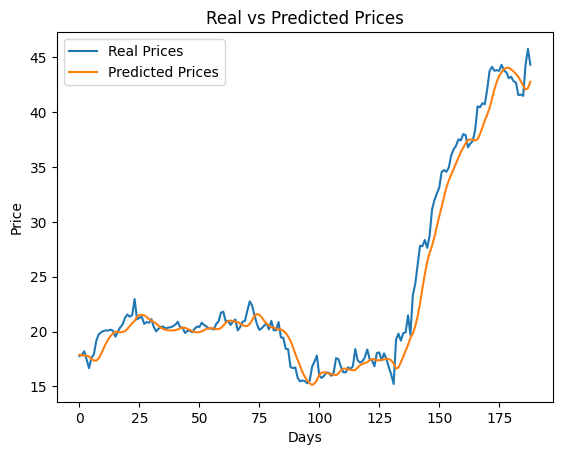

In [ ]:
# Step 7: Plot the predicted vs real prices
plt.plot(real_prices, label='Real Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.title('Real vs Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()